## Author

**Full Name: Yiğit Yalın**

**Student ID: 22002178**

### Import the required libraries

In [1]:
from enum import IntEnum
from scipy.optimize import minimize
from tabulate import tabulate
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.set_printoptions(precision=5)

# Problem 1: Value Iteration/Policy Iteration/Q-Learning and Linear Programming

## Enumerate the states

In [2]:
class States(IntEnum):
    BAD = 0
    GOOD = 1

## Enumerate the actions

In [3]:
class Actions(IntEnum):
    DONT_USE = 0
    USE = 1

## Define the cost function

Note that int(False) returns 0 and int(True) returns 1.

In [4]:
def c(state, action, eta):
    return eta * action - int(state == States.GOOD and action == Actions.USE)

## Define the discount factor

Let $\beta = 0.9 \in (0, 1)$

In [5]:
beta = 0.9

## Construct the one-step transition matrices

In [6]:
P_dont_use = np.array([
    [0.2, 0.8],
    [0.2, 0.8]
])

print(P_dont_use)

[[0.2 0.8]
 [0.2 0.8]]


In [7]:
P_use = np.array([
    [0.5, 0.5],
    [0.6, 0.4]
])

print(P_use)

[[0.5 0.5]
 [0.6 0.4]]


In [8]:
P = np.concatenate([P_dont_use[np.newaxis, ...], P_use[np.newaxis, ...]], axis=0)

print(P)

[[[0.2 0.8]
  [0.2 0.8]]

 [[0.5 0.5]
  [0.6 0.4]]]


## Apply value iteration algorithm to obtain the optimal solution

In [9]:
epsilon = 1e-7
max_iterations = 10000
values = []
etas = [0.01, 0.75, 0.85]

for eta in etas:
    v = np.zeros(len(States))
    
    for iteration in range(1, max_iterations + 1):
        delta = 0
        for state in States:
            state_action_values = np.zeros(len(Actions))
            
            for action in Actions:
                cost = c(state, action, eta)
                s = np.sum([
                    P[action][state][next_state] * v[next_state]
                    for next_state in States
                ])
                
                state_action_values[action] = cost + beta * s
            
            delta = max(delta, np.abs(state_action_values.min() - v[state]))
            v[state] = state_action_values.min()
        
        if delta < epsilon:
            break
    
    values.append(v.copy())
    
values = np.array(values)

In [10]:
print(tabulate(zip(etas, *values.transpose()),
               headers=['eta', 'State "Bad"', 'State "Good"'],
               tablefmt='fancy_grid'))

╒═══════╤═══════════════╤════════════════╕
│   eta │   State "Bad" │   State "Good" │
╞═══════╪═══════════════╪════════════════╡
│  0.01 │     -5.24118  │      -5.96912  │
├───────┼───────────────┼────────────────┤
│  0.75 │     -1.32353  │      -1.50735  │
├───────┼───────────────┼────────────────┤
│  0.85 │     -0.794117 │      -0.904411 │
╘═══════╧═══════════════╧════════════════╛


In [11]:
def get_best_action(state, values, eta):
    state_action_values = np.zeros(len(Actions))
    
    for action in Actions:
        cost = c(state, action, eta)
        s = np.sum([
            P[action][state][next_state] * values[next_state]
            for next_state in States
        ])
        
        state_action_values[action] = cost + beta * s
        
    return state_action_values.argmin()

The best actions for each state for each $\eta$:

In [12]:
best_actions = np.array([
    [get_best_action(state, value, eta) for eta, value in zip(etas, values)]
    for state in States
])

print(tabulate(zip(etas, *best_actions),
               headers=['eta', 'State "Bad"', 'State "Good"'],
               tablefmt='fancy_grid'))

╒═══════╤═══════════════╤════════════════╕
│   eta │   State "Bad" │   State "Good" │
╞═══════╪═══════════════╪════════════════╡
│  0.01 │             0 │              1 │
├───────┼───────────────┼────────────────┤
│  0.75 │             0 │              1 │
├───────┼───────────────┼────────────────┤
│  0.85 │             0 │              1 │
╘═══════╧═══════════════╧════════════════╛


Hence, we should not try to use the channel when the channel state is bad, and we should try to use the channel when channel state is good.

## Apply policy iteration algorithm to obtain the optimal solution

### Define a function to generate random policies

In [13]:
def generate_policy():
    return np.array([
        np.random.dirichlet(np.ones(len(States))) 
        for _ in range(len(Actions))
    ])

print(generate_policy())

[[0.72586 0.27414]
 [0.36545 0.63455]]


### Define the policy evaluation function

In [14]:
def evaluate_policy(pi, beta, eta, epsilon, max_iterations=1000):
    v = np.zeros(len(States))

    for _ in range(max_iterations):
        v_new = np.zeros(len(States))
        for state in States:
            for action in Actions:
                s = np.sum([
                    P[action][state][next_state] * v[next_state]
                    for next_state in States
                ])

                cost = c(state, action, eta)

                v_new[state] += pi[state][action] * (cost + beta * s)
            
        v = v_new
    return v_new

In [15]:
epsilon = 1e-7
max_iterations = 10000
policies = []
etas = [0.01, 0.75, 0.85]

for eta in etas:
    pi = generate_policy()
    
    for iteration in range(1, max_iterations + 1):
        pi_stable = True
        v = evaluate_policy(pi, beta, eta, epsilon)
        
        for state in States:
            values = np.zeros(len(Actions))
            for action in Actions:
                cost = c(state, action, eta)
                s = np.sum([
                    P[action][state][next_state] * v[next_state]
                    for next_state in States
                ])
                
                values[action] = cost + beta * s
                
            best_action = values.argmin()
            policy_action = pi[state].argmax()
            
            if best_action != policy_action:
                pi_stable = False
                
            pi[state] = np.identity(len(Actions))[best_action]
        
        if pi_stable:
            break
    
    policies.append(pi)

policies = np.array(policies)

In [16]:
values = np.array([
    evaluate_policy(policy, beta, eta, epsilon) 
    for eta, policy in zip(etas, policies)
])

print(tabulate(zip(etas, *values.transpose()),
               headers=['eta', 'State "Bad"', 'State "Good"'],
               tablefmt='fancy_grid'))

╒═══════╤═══════════════╤════════════════╕
│   eta │   State "Bad" │   State "Good" │
╞═══════╪═══════════════╪════════════════╡
│  0.01 │     -5.24118  │      -5.96912  │
├───────┼───────────────┼────────────────┤
│  0.75 │     -1.32353  │      -1.50735  │
├───────┼───────────────┼────────────────┤
│  0.85 │     -0.794118 │      -0.904412 │
╘═══════╧═══════════════╧════════════════╛


In [17]:
print(tabulate(zip(
    etas, 
    map(lambda action: Actions(action).name, policies.argmax(axis=-1)[..., 0]),
    map(lambda action: Actions(action).name, policies.argmax(axis=-1)[..., 1])
), headers=['eta', 'State "Bad"', 'State "Good"'], tablefmt='fancy_grid'))

╒═══════╤═══════════════╤════════════════╕
│   eta │ State "Bad"   │ State "Good"   │
╞═══════╪═══════════════╪════════════════╡
│  0.01 │ DONT_USE      │ USE            │
├───────┼───────────────┼────────────────┤
│  0.75 │ DONT_USE      │ USE            │
├───────┼───────────────┼────────────────┤
│  0.85 │ DONT_USE      │ USE            │
╘═══════╧═══════════════╧════════════════╛


Notice that we obtained the same results as in value iteration.

## Apply Q-Learning algorithm to obtain the optimal solution

In [18]:
def alpha(state, action, n_occurences):
    return 20 / (20 + n_occurences[state][action])

In [19]:
def get_starting_state():
    return np.random.choice(States)

In [20]:
def get_next_state(state, action):
    return np.random.choice(States, p=P[action][state])

In [21]:
def epsilon_decay_schedule(episode):
    return 1 / np.log10(10 + episode)

def epsilon_greedy_policy(state, q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(Actions)
    else:
        return np.argmin(q_values[state])

In [22]:
max_iterations = 1000000
q_values = np.zeros((len(States), len(Actions)))
n_occurences = np.zeros((len(States), len(Actions)))
eta = 0.75


state = get_starting_state()
for iteration in tqdm(range(1, max_iterations + 1)):
    epsilon = epsilon_decay_schedule(iteration)
    action = epsilon_greedy_policy(state, q_values, epsilon)
    cost = c(state, action, eta)

    next_state = get_next_state(state, action)
    td = cost + beta * q_values[next_state].min() - q_values[state][action]
    
    q_values[state][action] += alpha(state, action, n_occurences) * td
    n_occurences[state][action] += 1
    
    state = next_state

100%|██████████████████████████████| 1000000/1000000 [01:29<00:00, 11206.75it/s]


We obtained approximately the same results as in value and policy iterations. We would need more iterations to converge to the same value.

In [23]:
print(tabulate(zip(
    map(lambda action: action.name, Actions), 
    *q_values.transpose()
), headers=['Actions', 'State "Bad"', 'State "Good"'], tablefmt='fancy_grid'))

╒═══════════╤═══════════════╤════════════════╕
│ Actions   │   State "Bad" │   State "Good" │
╞═══════════╪═══════════════╪════════════════╡
│ DONT_USE  │      -1.32402 │      -0.523792 │
├───────────┼───────────────┼────────────────┤
│ USE       │      -1.3237  │      -1.50791  │
╘═══════════╧═══════════════╧════════════════╛


In [24]:
print(tabulate(zip(
    [eta], 
    [epsilon_greedy_policy(States.BAD, q_values, epsilon=0)],
    [epsilon_greedy_policy(States.GOOD, q_values, epsilon=0)]
), headers=['eta', 'State "Bad"', 'State "Good"'], tablefmt='fancy_grid'))

╒═══════╤═══════════════╤════════════════╕
│   eta │   State "Bad" │   State "Good" │
╞═══════╪═══════════════╪════════════════╡
│  0.75 │             0 │              1 │
╘═══════╧═══════════════╧════════════════╛


## Convex analytic method for average cost optimality

From the convex analytic method, an optimal policy will be stationary and deterministic.

Let

$$
\gamma(u = 0 \vert x = B) = 1 - \alpha
$$

$$
\gamma(u = 1 \vert x = B) = \alpha
$$

$$
\gamma(u = 0 \vert x = G) = 1 - \beta
$$

$$
\gamma(u = 1 \vert x = G) = \beta
$$

and $\pi$ be the corresponding invarient probability meaure. Then,

$$
\pi(B) = \dfrac{0.2 + 0.4\beta}{1 - 0.3\alpha + 0.4\beta}
$$

$$
\pi(G) = \dfrac{0.8 - 0.3\alpha}{1 - 0.3\alpha + 0.4\beta}
$$

Hence, our objective is to minimize

$$
J(x_0, \gamma) = \pi(B) \alpha \eta + \pi(G) \beta(\eta - 1)
$$

$$
= \dfrac{0.2 + 0.4\beta}{1 - 0.3\alpha + 0.4\beta} \alpha \eta + \dfrac{0.8 - 0.3\alpha}{1 - 0.3\alpha + 0.4\beta} \beta(\eta - 1)
$$

$$
= \dfrac{2\eta\alpha + (\eta+3)\alpha\beta + 8(\eta-1)\beta}
{10 - 3 \alpha + 4 \beta}
$$

Recall that an optimal policy will be deterministic, and we have 4 possibilities for $\alpha$ and $\beta$ such that


$\alpha = 0$ and $\beta = 0$ $\implies J(x_0, \gamma) = 0$

$\alpha = 0$ and $\beta = 1$ $\implies J(x_0, \gamma) = \dfrac{4}{7}(\eta - 1)$

$\alpha = 1$ and $\beta = 0$ $\implies J(x_0, \gamma) = \dfrac{2}{7}\eta$

$\alpha = 1$ and $\beta = 1$ $\implies J(x_0, \gamma) = \eta - \dfrac{5}{11}$

Hence, 

$$
\min_{\gamma}J(x_0, \gamma) = \min(0, \dfrac{4}{7}(\eta - 1), \dfrac{2}{7}\eta, \eta - \dfrac{5}{11})
$$

and an optimal policy is deterministic with the values of $\alpha$ and $\beta$ that minimizes $J(x_0, \gamma)$.

Let $\eta = 0.75$. From the discussion above, we know that $\alpha = 0$ and $\beta = 1$ is optimal for $\eta = 0.75$.

In [25]:
def objective(x, eta=0.75):
    alpha = x[0]
    beta = x[1]
    d = 2 * eta * alpha + (eta + 3) * alpha * beta + 8 * (eta - 1) * beta
    n = 10 - 3 * alpha + 4 * beta
    return d / n

In [26]:
bounds = ((0, 1), (0, 1))

Let us inject our prior knowledge to the algorithm.

In [27]:
x0 = [0, 1]

print(x0)

[0, 1]


In [28]:
minimized = minimize(objective, x0, bounds=bounds, method='SLSQP')

print('Minimum value:', minimized.fun)
print(f'Optimal policy: alpha={minimized.x[0]}, beta={minimized.x[1]}')

Minimum value: -0.14285714285714285
Optimal policy: alpha=0.0, beta=1.0


We do not need any prior knowledge at all:

In [29]:
x0 = np.random.rand(2)

print(x0)

[0.52901 0.86447]


In [30]:
minimized = minimize(objective, x0, bounds=bounds, method='SLSQP')

print('Minimum value:', minimized.fun)
print(f'Optimal policy: alpha={minimized.x[0]}, beta={minimized.x[1]}')

Minimum value: -0.14285714285714246
Optimal policy: alpha=9.5708770726464e-16, beta=0.9999999999999994


Note that we minimized the function using Sequential Least Squares Programming (SLSQP) because our objective was not linear in $\alpha$ and $\beta$.

# Problem 2: The Kalman Filter

Consider the following controlled linear system.

$$ x_{t+1} = Ax_t + w_t $$
$$ y_t = Cx_t + v_t $$

Define

$$ W = \mathbf{E}[w_tw_t^T] $$
$$ V = \mathbf{E}[v_tv_t^T] $$

$$ m_t = \mathbf{E}[x_t \lvert y_{[0, t-1]}] $$
$$ \Sigma_{t+1 \lvert t} = \mathbf{E}[(x - \mathbf{E}[x_t \lvert y_{[0, t-1]}])(x - \mathbf{E}[x_t \lvert y_{[0, t-1]}])^T \lvert y_{[0, t-1]}] $$

Then, with

$$ m_0 = \mathbf{E}[x_0] $$
$$ \Sigma_{0 \lvert -1} = \mathbf{E}[x_0x_0^T] $$

the following holds

$$ m_{t+1} = A m_t + A \Sigma_{t \lvert t - 1} C^T (C \Sigma_{t \lvert t - 1} C^T + V)^{-1} (y_t - C m_t) $$
$$ \Sigma_{t + 1 \lvert t} = A \Sigma_{t \lvert t - 1} A^T + W - (A \Sigma_{t \lvert t - 1} C^T)(C \Sigma_{t \lvert t - 1} C^T + V)^{-1} (C \Sigma_{t \lvert t - 1} A^T) $$

### Kalman Filter Implementation

In [31]:
def calculate_m(A, C, V, m, sigma, y):
    return A @ m + np.expand_dims(A @ sigma @ C.T, axis=1) @ np.linalg.inv(C @ sigma @ C.T + V) @ np.expand_dims(y - C @ m, axis=0)

In [32]:
def calculate_sigma(A, C, W, V, m, sigma, y):
    return A @ sigma @ A.T + W - np.expand_dims(A @ sigma @ C.T, axis=1) @ np.linalg.inv(C @ sigma @ C.T + V) @ np.expand_dims(C @ sigma @ A.T, axis=0)

In [33]:
A = np.array([
    [0.5, 1, 0],
    [0, 0.5, 1],
    [0, 0, 0.5]
])

print(A)

[[0.5 1.  0. ]
 [0.  0.5 1. ]
 [0.  0.  0.5]]


In [34]:
C = np.array([4, 0, 0])

print(C)

[4 0 0]


In [35]:
W = np.identity(3)

print(W)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [36]:
V = np.ones(shape=(1, 1))

print(V)

[[1.]]


In [37]:
def generate_w():
    return np.random.multivariate_normal(mean=np.zeros(3), cov=np.identity(3))

In [38]:
def generate_v():
    return np.random.normal()

In [39]:
T = 1000

w = generate_w()
v = generate_v()
x = np.random.multivariate_normal(mean=np.zeros(3), cov=np.identity(3))
y = C @ x + v

m = np.zeros(3)
sigma = np.identity(3)

xs = [x]
ms = [m]

for t in range(T):
    w = generate_w()
    v = generate_v()
    
    x = A @ x + w
    y = C @ x + v
    
    m = calculate_m(A, C, V, m, sigma, y)
    sigma = calculate_sigma(A, C, W, V, m, sigma, y)
    
    xs.append(x)
    ms.append(m)

In [40]:
xs = np.array(xs)
ms = np.array(ms)

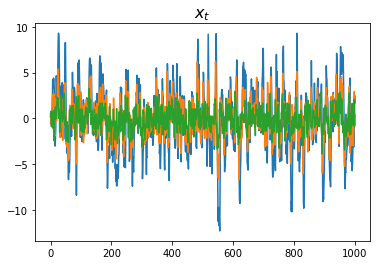

In [41]:
plt.plot(xs)
plt.title('$x_t$', fontsize=16)
plt.show()

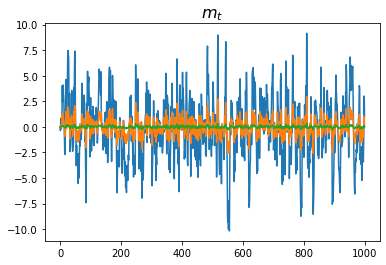

In [42]:
plt.plot(ms)
plt.title('$m_t$', fontsize=16)
plt.show()

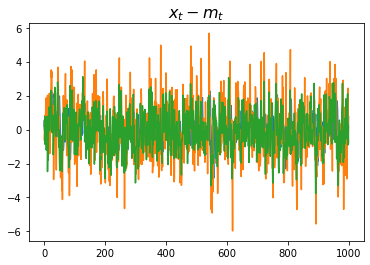

In [43]:
plt.plot(xs - ms)
plt.title('$x_t - m_t$', fontsize=16)
plt.show()

In [44]:
xs.mean(axis=0)

array([-0.23247, -0.07298, -0.09525])

In [45]:
ms.mean(axis=0)

array([-0.18886, -0.04356, -0.00437])

In [46]:
(xs - ms).mean(axis=0)

array([-0.04361, -0.02942, -0.09088])

The Ricatti recursions converge to a fixed point if $(A^T, C^T)$ is controllable (or $(A, C)$ is observable) and $V>0$. This fixed point is unique if, in addition, $(A, B)$ is controllable (or $(A^T, B^T)$ is observable) with $W = BB^T$.

Recall our system:

$$ x_{t+1} = Ax_t + w_t $$
$$ y_t = Cx_t + v_t $$

The system is observable if and only if the observability matrix has rank $n$, where $n$ is the dimension of the measurements (which is 3 in our case).

In [47]:
def calculate_observability_matrix(A, C):
    measurement_dimension = A.shape[1]
    O = [C]
    A_powers = A
    for _ in range(1, measurement_dimension):
        row = C @ A_powers
        O.append(row)
        A_powers = A_powers @ A
    return np.array(O)

In [48]:
O = calculate_observability_matrix(A, C)

print(O)

[[4. 0. 0.]
 [2. 4. 0.]
 [1. 4. 4.]]


In [49]:
print('Measurement dimensions:', A.shape[1])
print('Observability matrix rank:', np.linalg.matrix_rank(O))

Measurement dimensions: 3
Observability matrix rank: 3


Then, the system satisfies the observability condition for $(A, C)$.

In [50]:
T = 1000

all_sigmas = []

for i in range(5):
    w = generate_w()
    v = generate_v()
    x = np.random.multivariate_normal(mean=np.zeros(3), cov=np.identity(3))
    y = C @ x + v
    

    m = np.zeros(3)
    sigma = np.identity(3) * (i + 1)

    sigmas = [sigma]
    
    for t in range(T):
        w = generate_w()
        v = generate_v()

        x = A @ x + w
        y = C @ x + v

        m = calculate_m(A, C, V, m, sigma, y)
        sigma = calculate_sigma(A, C, W, V, m, sigma, y)

        sigmas.append(sigma)
    all_sigmas.append(sigmas)

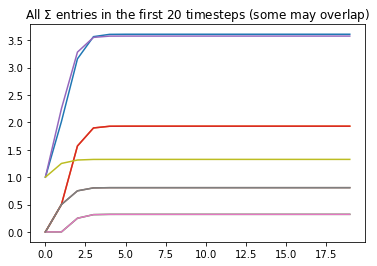

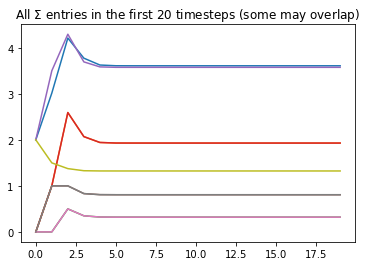

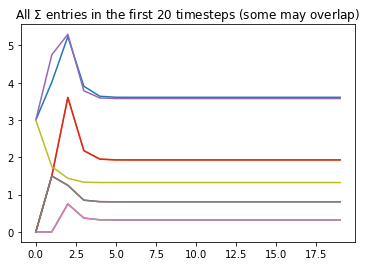

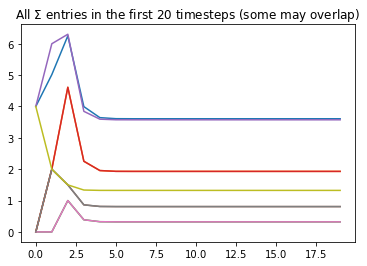

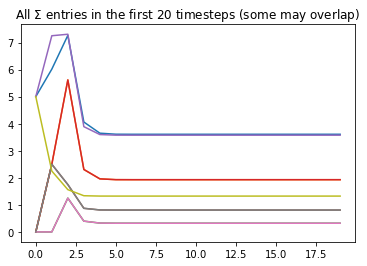

In [51]:
for sigmas in all_sigmas:
    plt.figure()
    flat = np.array([
        sigma.flatten()
        for sigma in sigmas
    ])
    plt.plot(flat[:20])
    plt.title('All $\Sigma$ entries in the first 20 timesteps (some may overlap)')
    plt.show()

We can observe that, for all initial values, the Ricatti equation converges to a fixed point in the first few timesteps. In fact, they all converge to the same fixed point as we can see in the following plot.

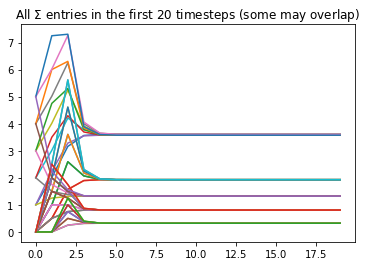

In [52]:
plt.figure()
for sigmas in all_sigmas:
    flat = np.array([
        sigma.flatten()
        for sigma in sigmas
    ])
    plt.plot(flat[:20])
    plt.title('All $\Sigma$ entries in the first 20 timesteps (some may overlap)')
plt.show()